### ML acidoCEST Figure 03 Iopamido Regression

### To -do list
- [ ] Panel A classic calibration

In [1]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

import curve_fitting as cf
import imp
imp.reload(cf)

def center_ppm(xdata,Y):
    return xdata - xdata[np.argmax(1-Y)]
    

In [304]:
def get_data(mol_n):
    molecules = ['Polymer',' Monomer 2 (M2)','Monomer 1 (M1)','Iopamidol','Gadolinium in 20mM Iopamidol']
    
    data_file ='../data/raw/CEST-ML-format_cjk_20190528_updated polymer saturation power.xlsx'
    
    print(molecules[mol_n])
    df = pd.read_excel(data_file, sheetname= molecules[mol_n])
    
    info = df[['Sample ID', 'pH', 'concentration_mM','temperature_C', 'sat time_sec','sat power_uT']]
    pH = info['pH'].copy()
    print('Info shape \n',info.shape)
    print('--'*10)
    X = df.select_dtypes(include=['float64']).drop(['pH', 'sat time_sec',     'sat power_uT'],axis = 1)
    print('X shape \n', X.shape )
    print('--'*10)
    for C in info.columns:  
        print(info[C].nunique(), C + ' unique values')
        print('--'*10)
        
    return info, pH, X

In [305]:
### define function to train model based on cuttoff for pH
def train_linear_regression(Spectra, pH_observed):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )

    # Training parameters
    param_grid ={
    'normalize': [True,False],
        'fit_intercept':[False,True]
    }
    
    
    estimator = GridSearchCV(linear, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
        
    return estimator.best_estimator_

### define function to train model based on cuttoff for pH
def train_linear_reg_pipeline(Spectra, pH_observed, min_n=2, max_n= 10):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )
    
    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)


    param_grid ={
    'pca__n_components': num_pca_components,
    'linear__normalize': [True,False],
    'linear__fit_intercept':[True,False]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model"
    estimator.fit(X_train, y_train)

    
    return estimator.best_estimator_

### Get raw data for Iopamidol

In [270]:
info.shape

(585, 10)

In [273]:
info['id']= np.arange(info.shape[0])

info2 = info.drop_duplicates(subset=['concentration_mM', 'temperature_C','sat time_sec','sat power_uT','pH'])
info2.groupby(['concentration_mM','temperature_C','sat time_sec','sat power_uT']).size()

concentration_mM  temperature_C  sat time_sec  sat power_uT
1                 37             6.0           4.0             15
5                 37             6.0           4.0             15
10                37             6.0           4.0             15
15                37             6.0           4.0             15
20                37             6.0           4.0             15
30                27             6.0           4.0             15
                  32             6.0           4.0             15
                  37             0.5           4.0             15
                                 1.0           4.0             15
                                 1.5           4.0             15
                                 2.0           4.0             15
                                 3.0           4.0             15
                                 4.0           4.0             15
                                 6.0           0.5             15
                

In [246]:
info.head(2)

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
0,Iopamidol,6.00,30,37,6.0,0.5,0.007799,0.014624,-0.273045
1,NaN,6.15,30,37,6.0,0.5,0.009530,0.017865,-0.272914


In [307]:
info.groupby(['concentration_mM','temperature_C','sat time_sec','sat power_uT','pH']).size().to_excel('temp.xlsx')

In [245]:
info.concentration_mM.value_counts(normalize=0)

50    255
30    255
20     15
15     15
10     15
5      15
1      15
Name: concentration_mM, dtype: int64

In [253]:
7*5*7

245

In [306]:
info, pH, X = get_data(3)

Iopamidol
Info shape 
 (615, 6)
--------------------
X shape 
 (615, 142)
--------------------
1 Sample ID unique values
--------------------
15 pH unique values
--------------------
7 concentration_mM unique values
--------------------
5 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
6 sat power_uT unique values
--------------------


## Lorentzian Fitting Parameters

In [6]:
a1= .9
a2= .7
a3= .5
a4= .5

w1= 1
w2= 1
w3= 1
w4= 1

c1= 0
c2= 1
c3= 4.2
c4= 5.6

x0 = [a1,a2,a3,a4,   w1,w2,w3,w4,  c1,    c2,   c3,   c4,  1]
lb = [.1, 0,0,  0,   .1,.1,.1,.1,  c1-.1, .5,   c3-1, c4-.5,   -2]
ub = [1, .7,1,1,    3, 2, 2, 2,    c1+.1, 2.0 , c3+1, c4+.5, 2]  

d = pd.DataFrame(lb, columns=['lb'])
d['xo'] = x0
d['ub'] = ub

d.index = ['A1','A2','A3','A4','W1','W2','W3','W4','C1','C2','C3','C4','Scaling']
d

,lb,xo,ub
A1,0.1,0.9,1.0
A2,0.0,0.7,0.7
A3,0.0,0.5,1.0
A4,0.0,0.5,1.0
W1,0.1,1.0,3.0
W2,0.1,1.0,2.0
W3,0.1,1.0,2.0
W4,0.1,1.0,2.0
C1,-0.1,0.0,0.1
C2,0.5,1.0,2.0


### Test some of the fitting

Sample ID            NaN
pH                  6.75
concentration_mM      30
temperature_C         37
sat time_sec           6
sat power_uT         0.5
Name: 5, dtype: object


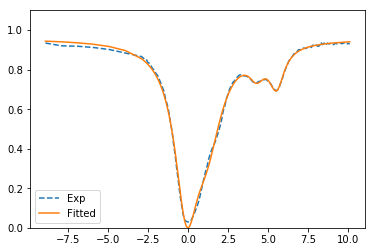

In [7]:
f = 5
s = 540


print(info.iloc[5,:])

y_data =  X.iloc[s,:].values[f::]
x_data =  center_ppm( X.columns.values[f::], y_data)

par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
yhat = cf.lorentzian(x_data,par_hat)

plt.figure()
plt.plot(x_data, y_data,'--')
plt.plot(x_data, 1-yhat,'-')
plt.legend(['Exp','Fitted'])
plt.ylim([0,1.1])
plt.show()



### Lorentzian Fitting

In [9]:
%%time
info = info.assign(Peak_4p2 = 1)
info = info.assign(Peak_5p6 = 1)
peak_01 = []
peak_02 = []

for s in range(X.shape[0]):
    y_data =  X.iloc[s,:].values[f::]
    x_data =  center_ppm( X.columns.values[f::], y_data)
    par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
    peak_01.append(par_hat[2])
    peak_02.append(par_hat[3])
    
    # peaks for ratiometric approach
    info.loc[s,'Peak_4p2'] = ( 1-(1-par_hat[2]) ) / (1-par_hat[2])   #par_hat[2]
    info.loc[s,'Peak_5p6'] = ( 1-(1-par_hat[3]) ) / (1-par_hat[3])   # par_hat[3]
    

CPU times: user 1min 4s, sys: 197 ms, total: 1min 4s
Wall time: 1min 4s


### - Calibration Curve: Method 01: Lorentzian ---> Some exp conditions

Coef [0.88098966]
intercept_ 6.34167143818629


/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


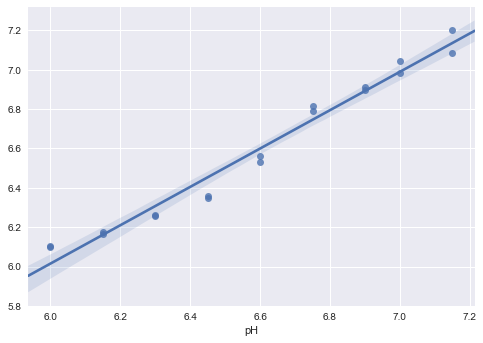

In [274]:
def cal_curve_classic():
    info['RATIO'] = np.log10( info['Peak_4p2'] / info['Peak_5p6'])

    f1 = info.concentration_mM == 30
    f2 = info.temperature_C == 37
    f3 = info['sat time_sec'] == 6
    f4 = info['sat power_uT'] ==4
    d = info[f1&f2&f3&f4]
    d = d[d.pH <= 7.2]

    Xd = d['RATIO'].values.reshape(-1,1)

    LR = linear_model.LinearRegression(  fit_intercept=True)
    LR.fit(Xd,d.pH)
    pHhat = LR.predict(Xd)
    
    return LR, Xd, d.pH


model_01 , Xd01, pH01 = cal_curve_classic()
print( 'Coef', model_01.coef_)
print( 'intercept_', model_01.intercept_)

sns.regplot(x=pH01, y=model_01.predict(Xd01))

### - Calibration Curve: Method 02: Lorentzian ---> `ALL` exp conditions & Cross validation

In [281]:
f1 = info2['sat power_uT'] == 4
f2 = info2['temperature_C'] == 37
f3 = info2['sat time_sec'] == 6.0

info3 = info2[f1&f2&f3].copy()


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Coef [[0.81094276]]
intercept_ [6.36420612]


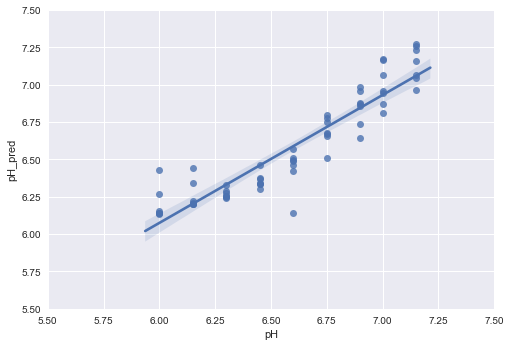

In [298]:
def cal_curve_classic_all_exp(cut = 7.2):
    
    d = info3[info3.pH <= cut]
    
    X = d.RATIO.replace([np.inf],[0]).values.reshape(-1,1)
    y = d.pH.values.reshape(-1,1)
    
    LR2 = train_linear_regression(X,y) 
    
    #LR2 = linear_model.LinearRegression(  fit_intercept=True)
    #LR2.fit(X,y)

    
    return LR2, X, y, d

model_02 , Xd02, pH02, d = cal_curve_classic_all_exp(cut = 7.2)

z = pd.DataFrame(pH02, columns=['pH'])
z['pH_pred'] = model_02.predict(Xd02)
sns.regplot(x='pH', y='pH_pred', data=z)
plt.xlim([5.5, 7.5])
plt.ylim([5.5, 7.5])

print( 'Coef', model_02.coef_)
print( 'intercept_', model_02.intercept_)

In [294]:
pH02.shape

(63, 1)

In [299]:
d.concentration_mM.shape

(63,)

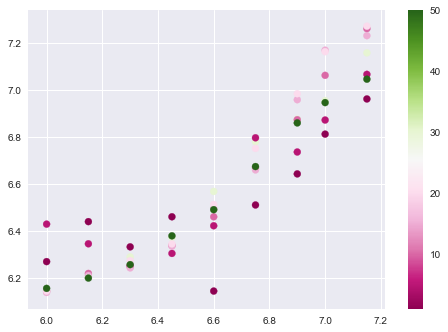

In [303]:
plt.scatter(pH02, model_02.predict(Xd02), c = d.concentration_mM, cmap='PiYG')
plt.colorbar()

In [227]:
z = pd.DataFrame(pH02, columns=['pH'])
z['pH_pred'] = model_02.predict(Xd02)
sns.regplot(x='pH', y='pH_pred', data=z)
plt.xlim([5.5, 7.5])
plt.ylim([5.5, 7.5])

print( 'Coef', model_02.coef_)
print( 'intercept_', model_02.intercept_)

array([[-0.26502383],
       [-0.20573067],
       [-0.08192083],
       [ 0.06461435],
       [ 0.25734247],
       [ 0.47297204],
       [ 0.85300502],
       [ 1.12229746],
       [ 1.60968846]])

In [228]:
metrics.r2_score(pH01, model_01.predict(Xd01))

0.9238072553445406

In [229]:
metrics.r2_score(pH02, model_01.predict(Xd02))

0.5607435916165995

In [230]:
metrics.r2_score(pH02, model_02.predict(Xd02))

0.6662576938356711

/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(5.5, 8.2)

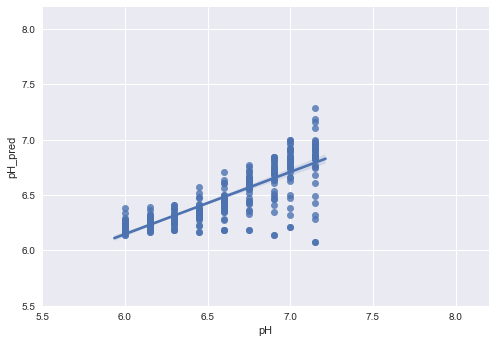

In [231]:


z2 = pd.DataFrame(pH02, columns=['pH'])
z2['pH_pred'] = model_01.predict(Xd02)
sns.regplot(x='pH', y='pH_pred', data=z2)
plt.xlim([5.5, 8.2])
plt.ylim([5.5, 8.2])

### - Calibration Curve: Method 03: Entire Spectra ---> PCA ---> `ALL` exp conditions & Cross validation

In [232]:
cut = 7.2
f = pH <= cut
Xd03 = X[f]
pH03 = pH[f]

model_03 = train_linear_reg_pipeline(Xd03, pH03, min_n=2, max_n= 100)

Fitting 3 folds for each of 392 candidates, totalling 1176 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 1176 out of 1176 | elapsed:    7.8s finished


In [233]:
metrics.r2_score(pH03, model_03.predict(Xd03))

0.8203225079163803

In [234]:
print(model_03.named_steps['pca'].n_components)
print( 'Coef', model_02.coef_)
print( 'intercept_', model_02.intercept_)

33
Coef [[0.68476951]]
intercept_ [6.43379572]


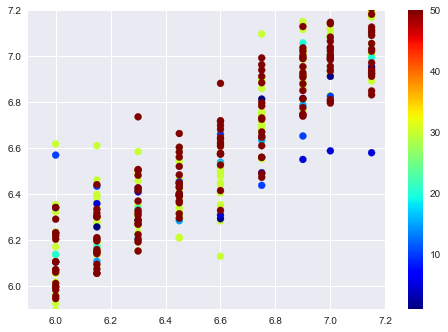

In [235]:
plt.scatter(pH03,model_03.predict(Xd03), c= info['concentration_mM'][f], cmap='jet')
plt.xlim([5.9, cut])
plt.ylim([5.9, cut])
plt.colorbar()

In [236]:
import statsmodels.api as sm
from sklearn.preprocessing import scale

error = pd.DataFrame( pH03 - model_03.predict(Xd03))
error.columns=['Res']

pred= info[f][['pH','concentration_mM', 'temperature_C', 'sat time_sec','sat power_uT','Peak_4p2', 'Peak_5p6']]
df= pd.merge(pred, error, right_index=True, left_index=True)

#pred['Int'] = 1

mod  = sm.OLS(error,pred.apply(scale))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    Res   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     23.17
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           9.98e-26
Time:                        16:48:25   Log-Likelihood:                 217.62
No. Observations:                 351   AIC:                            -421.2
Df Residuals:                     344   BIC:                            -394.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pH                   0.1297      0.011  

/Users/Julio/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/Julio/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


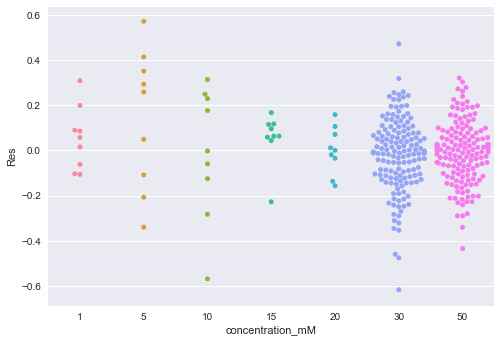

In [240]:
sns.swarmplot(x='concentration_mM', y= 'Res', data = df)

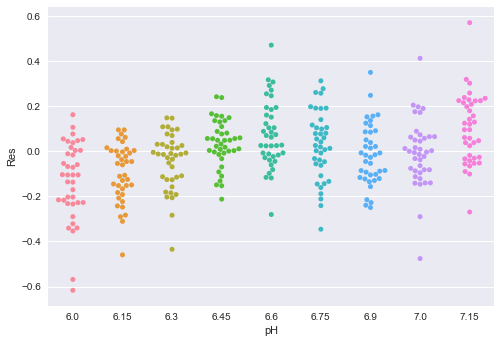

In [239]:
sns.swarmplot(x='pH', y= 'Res', data = df)

In [ ]:
'sat power_uT'

In [72]:
model_03.named_steps['linear'].coe

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, dpi=100)

ax1.plot(d.pH, pHhat,'o')
ax1.set_title('Calibration Curve')
#ax1.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(d.pH,LR.predict(Xd)))


## Apply Calibriton to everything

I = info[info.pH <= 7.4]

Xd = I['RATIO'].replace(np.inf,0)
Xd = Xd.values.reshape(-1,1)

yd = I.pH.copy()

pHhat1 = LR.predict(Xd)


ax2.plot(yd, pHhat1,'o')
ax2.set_title('Applied to all samples')

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat1))

ax3.hist( (yd - pHhat1)**2)

## Train on all variables and test on all data

In [ ]:
model_all = train_linear_regression(Xd, yd)

pHhat2 = model_all.predict(Xd)

plt.scatter(yd, pHhat2)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat2))

### Train on Spectra and test on everything

In [ ]:
Xd = X[info.pH <= 7.4]
yd = info.pH[info.pH <= 7.4]

model_all = train_linear_regression(Xd, yd)

pHhat3 = model_all.predict(Xd)

plt.scatter(yd, pHhat3)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat3))

### Train on Spectra + PCA and test on everything

In [ ]:
Xd.shape

In [ ]:
model_pca = train_linear_reg_pipeline(Xd, yd, max_n= 125)

pHhat4 = model_pca.predict(Xd)

plt.scatter(yd, pHhat4)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])
plt.xlim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat4))

In [ ]:
model_pca

In [ ]:
plt.hist( (yd - pHhat4)**2)

#### Logistic Regression

In [ ]:
### define function to train model based on cuttoff for pH
def train_linear_reg_pipeline(Spectra, pH_observed, min_n=2, max_n= 10):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )
    
    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)


    param_grid ={
    'pca__n_components': num_pca_components,
    'linear__normalize': [True,False],
    'linear__fit_intercept':[True,False]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model"
    estimator.fit(X_train, y_train)

    
    return estimator.best_estimator_

In [ ]:
### define function to train model based on cuttoff for pH
def train_linear_regression(Spectra, pH_observed):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )

    # Training parameters
    param_grid ={
    'normalize': [True,False],
        'fit_intercept':[False,True]
    }
    
    
    estimator = GridSearchCV(linear, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
        
    return estimator.best_estimator_

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)

Note on metrics
- precision = positive predictive value
- recall    = sensitivity

###  -training pH >7.0  

In [ ]:
(pH> 7).value_counts(normalize = True).round(2)

### Pipeline

In [ ]:
s = X.shape[1]
step_size = 1

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:step_size], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 7.0, n_cs=20 )

clf_01

### Only Logistic Regression

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( X.iloc[:,0:s:step_size], pH,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### pH > 6.8

In [ ]:
(pH > 6.8).value_counts(normalize = True).round(2)

In [ ]:
clf_pca, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:1], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 6.8, n_cs=20 )
clf_pca

For Mart

In [ ]:
pca = clf_pca.named_steps['pca']

In [ ]:
pca.transform(X.iloc[250:251,:])

In [ ]:
clf_pca.predict(X)

In [ ]:
X

In [ ]:
model_pca

In [ ]:
pca_s = model_pca.named_steps['pca']

In [ ]:
np.linalg.matrix_rank( X)

In [ ]:
sns.heatmap( np.corrcoef( pca_s.transform(X) ), vmin=-1, vmax=1 )

In [ ]:
sns.heatmap?

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(np.corrcoef(X) , vmin=-1, vmax=1  )